In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x46.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,earliest_cr_line_month,earliest_cr_line_year,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.805788,0.544423,0.570300,0.663197,0.663194,-0.388527,-0.928141,0.020404,0.814165,0.277188,1.683433,0.681092,-0.074467,-0.125292,-0.377704,-0.220266,-0.283574,0.729709,1.019288,0.837092,0.319365,-0.684242,-0.017646,1.099265,-0.007523,-0.007523,-0.358603,-0.873547,-0.084014,-0.342123,-1.311086,-0.003071,-0.252444,-0.117473,6.888409,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,-0.372811,1.298703,-1.011585,1.0
1,0.650069,0.015948,0.055254,-1.040497,-1.040493,0.282002,0.487904,1.071777,-0.307337,0.416038,-0.902143,-0.383738,-0.074467,-0.125292,-0.377704,-0.808202,0.974220,0.729709,1.019288,0.837092,0.871554,-0.427946,-0.017646,1.099265,-0.007523,-0.007523,-0.358603,-0.873547,-0.084014,-0.342123,0.762727,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,2.682328,-0.769999,-1.011585,0.0
2,-0.232905,-0.522707,1.648144,3.583815,3.583802,-0.133801,-0.383561,1.071777,-0.067015,-0.358038,-0.040284,-0.383738,-0.074467,-0.125292,-0.377704,-1.690107,0.974220,0.729709,-0.981077,0.837092,0.595459,1.109835,-0.017646,-0.909699,-0.007523,-0.007523,2.788603,-0.873547,-0.084014,-0.342123,0.762727,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,2.682328,-0.769999,-1.011585,1.0
3,0.529186,0.644379,0.008638,-1.040497,-1.040493,-1.118991,0.203558,-0.154825,-0.067015,0.212601,-0.902143,-0.383738,-0.074467,-0.125292,-0.377704,0.367670,-1.960634,0.729709,1.019288,-0.426533,-0.232824,-0.940539,-0.017646,-0.909699,-0.007523,-0.007523,2.788603,-0.873547,11.902814,-0.342123,-1.311086,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,2.682328,-0.769999,-1.011585,0.0
4,1.780067,0.823931,1.743649,0.906582,0.906578,-1.118991,1.300984,2.298379,2.336203,-0.106754,-0.902143,0.681092,-0.074467,-0.125292,-0.377704,0.955607,-0.842594,0.729709,1.019288,-0.426533,-0.232824,0.597242,-0.017646,1.099265,-0.007523,-0.007523,-0.358603,-0.873547,-0.084014,-0.342123,0.762727,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,-0.372811,1.298703,-1.011585,1.0


In [4]:
data.shape

(106009, 46)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    62957
0.0    43052
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(106009, 45)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.61970569 0.61484766 0.61857372 0.62192246 0.62204613]
0.6194191307058758


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[11942, 31110],
       [ 9235, 53722]])

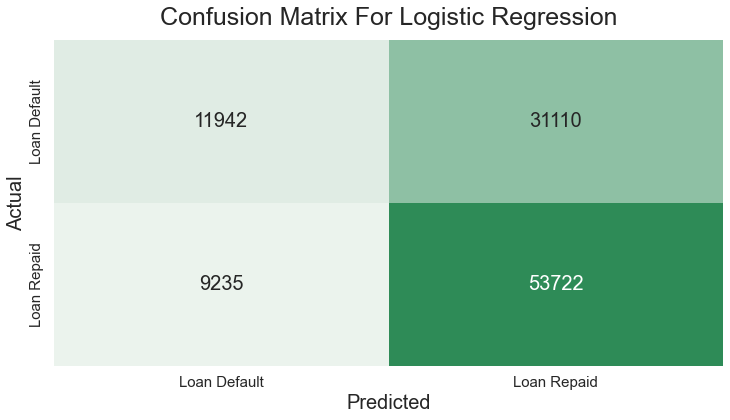

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.6194191059249686

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

53722
31110
9235
11942
0.6194191059249686


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    62957
0.0    43052
Name: loan_status_bin, dtype: int64

0.5938835381901537


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.6332751791776688

In [17]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [18]:
y_pred_prob

array([[0.40644899, 0.59355101],
       [0.44724802, 0.55275198],
       [0.42972539, 0.57027461],
       ...,
       [0.3124657 , 0.6875343 ],
       [0.37955868, 0.62044132],
       [0.23498084, 0.76501916]])

In [19]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[42556,   496],
       [60765,  2192]])

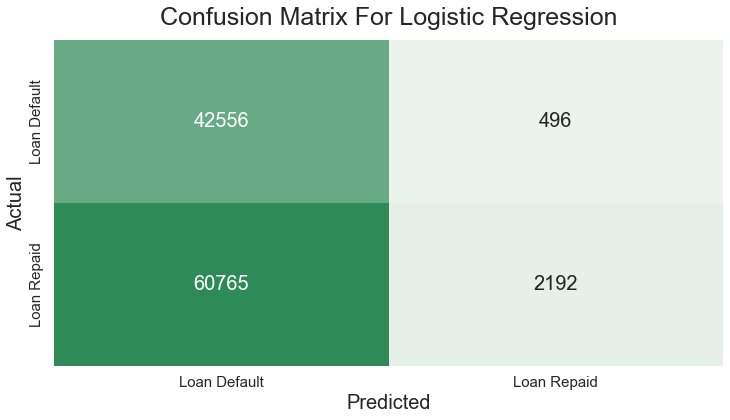

In [21]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [22]:
accuracy_score(y, y_pred_success)

0.42211510343461406

In [23]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

2192
496
60765
42556
0.42211510343461406


In [24]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 23% better than Null Model or "random investment"
TP / (TP+FP)

0.8154761904761905

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 